# Single Trader Deep Dive Analysis

Comprehensive analysis of an individual Polymarket trader with detailed visualizations.

## Features:
- Complete trading statistics and metrics
- Market participation analysis with full metadata
- Trade behavior patterns (timing, sizing, direction)
- PnL calculation (realized + unrealized)
- Win rate and performance metrics
- Market concentration analysis
- Trading style classification
- Time-based activity patterns
- Visual dashboards and charts

In [25]:
from __future__ import annotations

import warnings
from pathlib import Path
import sys

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Configure Polars display
pl.Config.set_tbl_rows(25)
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_width_chars(1000)

# Add project root to path
PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from poly_utils import get_markets, PLATFORM_WALLETS

print("✓ Imports loaded")

✓ Imports loaded


## 1. Load Data

In [26]:
# Load markets
markets_df = get_markets(
    main_file=str(PROJECT_ROOT / 'markets.csv'),
    missing_file=str(PROJECT_ROOT / 'missing_markets.csv')
)
markets_df = markets_df.rename({'id': 'market_id'})
print(f"Loaded {len(markets_df):,} markets")

# Load trades
TRADES_FILE = PROJECT_ROOT / 'processed' / 'latest_10000000_trades.parquet'

if TRADES_FILE.exists():
    trades = pl.read_parquet(TRADES_FILE)
else:
    print("⚠ Loading full CSV (this may take time)...")
    trades = pl.scan_csv(PROJECT_ROOT / 'processed' / 'trades.csv').collect(streaming=True)

if trades['timestamp'].dtype == pl.Utf8:
    trades = trades.with_columns(pl.col('timestamp').str.to_datetime())

print(f"Loaded {len(trades):,} trades")
print(f"Date range: {trades['timestamp'].min()} to {trades['timestamp'].max()}")

Loaded 176351 markets from /home/junel/random-walk-studio/polymarket/polymarket/markets.csv
Combined total: 175830 unique markets (sorted by createdAt)
Loaded 175,830 markets
Loaded 10,000,000 trades
Date range: 2025-11-12 03:32:21 to 2025-11-19 02:26:25


## 2. Select Trader to Analyze

In [27]:
# Option 1: Analyze a specific wallet address
# TRADER_ADDRESS = '0x...'  # Paste wallet address here

# Option 2: Analyze top trader by volume (default)
top_trader = (
    trades
    .group_by('maker')
    .agg(pl.col('usd_amount').sum().alias('volume'))
    .filter(~pl.col('maker').is_in(PLATFORM_WALLETS))
    .sort('volume', descending=True)
    .head(1)
)['maker'][0]

TRADER_ADDRESS = top_trader

# Option 3: Show top 10 traders and select by rank
print("=== Top 10 Traders by Volume ===")
top_10 = (
    trades
    .group_by('maker')
    .agg(
        pl.col('usd_amount').sum().alias('volume'),
        pl.len().alias('trades'),
        pl.col('market_id').n_unique().alias('markets')
    )
    .filter(~pl.col('maker').is_in(PLATFORM_WALLETS))
    .sort('volume', descending=True)
    .head(10)
)
for i, row in enumerate(top_10.iter_rows(named=True)):
    print(f"{i+1}. {row['maker'][:20]}... - ${row['volume']:,.0f} - {row['trades']:,} trades - {row['markets']} markets")

# To analyze a different trader, uncomment and set:
# TRADER_RANK = 2  # Change to desired rank (1-10)
# TRADER_ADDRESS = top_10['maker'][TRADER_RANK - 1]

print(f"\n✓ Analyzing trader: {TRADER_ADDRESS}")

=== Top 10 Traders by Volume ===
1. 0x31519628fb5e5aa559... - $12,081,206 - 5,478 trades - 214 markets
2. 0xb744f56635b537e859... - $7,594,974 - 4,492 trades - 44 markets
3. 0xed88d69d689f3e2f6d... - $6,726,984 - 1,247 trades - 25 markets
4. 0x507e52ef684ca2dd91... - $6,117,952 - 25,269 trades - 1347 markets
5. 0x76062e7bbfc0fb7834... - $5,971,887 - 896 trades - 30 markets
6. 0xe8dd7741ccb1235095... - $5,953,343 - 92,677 trades - 3443 markets
7. 0x3657862e57070b82a2... - $5,919,213 - 359 trades - 18 markets
8. 0x16b29c50f2439faf62... - $5,441,665 - 7,027 trades - 445 markets
9. 0x751a2b86cab503496e... - $5,391,739 - 5,383 trades - 1139 markets
10. 0xe60a9b0be459d9849b... - $5,345,331 - 50,331 trades - 964 markets

✓ Analyzing trader: 0x31519628fb5e5aa559d4ba27aa1248810b9f0977


## 3. Trader Overview Statistics

In [28]:
# Get all trades for this trader
trader_trades = trades.filter(pl.col('maker') == TRADER_ADDRESS.lower())

# Calculate overall statistics
stats = {
    'total_trades': len(trader_trades),
    'total_volume': trader_trades['usd_amount'].sum(),
    'avg_trade_size': trader_trades['usd_amount'].mean(),
    'median_trade_size': trader_trades['usd_amount'].median(),
    'max_trade_size': trader_trades['usd_amount'].max(),
    'min_trade_size': trader_trades['usd_amount'].min(),
    'unique_markets': trader_trades['market_id'].n_unique(),
    'buy_trades': len(trader_trades.filter(pl.col('maker_direction') == 'BUY')),
    'sell_trades': len(trader_trades.filter(pl.col('maker_direction') == 'SELL')),
    'buy_volume': trader_trades.filter(pl.col('maker_direction') == 'BUY')['usd_amount'].sum(),
    'sell_volume': trader_trades.filter(pl.col('maker_direction') == 'SELL')['usd_amount'].sum(),
    'first_trade': trader_trades['timestamp'].min(),
    'last_trade': trader_trades['timestamp'].max(),
}

stats['buy_ratio'] = stats['buy_trades'] / stats['total_trades']
stats['active_period'] = stats['last_trade'] - stats['first_trade']
stats['trades_per_day'] = stats['total_trades'] / max((stats['active_period'].total_seconds() / 86400), 1)

print("="*80)
print(f"TRADER ANALYSIS: {TRADER_ADDRESS}")
print("="*80)
print(f"\n📊 OVERALL STATISTICS")
print(f"{'─'*80}")
print(f"Total Trades:           {stats['total_trades']:,}")
print(f"Total Volume:           ${stats['total_volume']:,.2f}")
print(f"Unique Markets:         {stats['unique_markets']:,}")
print(f"\n💰 TRADE SIZES")
print(f"{'─'*80}")
print(f"Average Trade:          ${stats['avg_trade_size']:,.2f}")
print(f"Median Trade:           ${stats['median_trade_size']:,.2f}")
print(f"Largest Trade:          ${stats['max_trade_size']:,.2f}")
print(f"Smallest Trade:         ${stats['min_trade_size']:,.2f}")
print(f"\n📈 DIRECTIONAL BIAS")
print(f"{'─'*80}")
print(f"Buy Trades:             {stats['buy_trades']:,} ({stats['buy_ratio']:.1%})")
print(f"Sell Trades:            {stats['sell_trades']:,} ({1-stats['buy_ratio']:.1%})")
print(f"Buy Volume:             ${stats['buy_volume']:,.2f}")
print(f"Sell Volume:            ${stats['sell_volume']:,.2f}")
print(f"\n⏱️ ACTIVITY TIMELINE")
print(f"{'─'*80}")
print(f"First Trade:            {stats['first_trade']}")
print(f"Last Trade:             {stats['last_trade']}")
print(f"Active Period:          {stats['active_period']}")
print(f"Trades per Day:         {stats['trades_per_day']:.1f}")
print(f"\n")

TRADER ANALYSIS: 0x31519628fb5e5aa559d4ba27aa1248810b9f0977

📊 OVERALL STATISTICS
────────────────────────────────────────────────────────────────────────────────
Total Trades:           5,478
Total Volume:           $12,081,205.77
Unique Markets:         214

💰 TRADE SIZES
────────────────────────────────────────────────────────────────────────────────
Average Trade:          $2,205.40
Median Trade:           $28.39
Largest Trade:          $999,000.00
Smallest Trade:         $0.01

📈 DIRECTIONAL BIAS
────────────────────────────────────────────────────────────────────────────────
Buy Trades:             5,301 (96.8%)
Sell Trades:            177 (3.2%)
Buy Volume:             $11,944,890.63
Sell Volume:            $136,315.14

⏱️ ACTIVITY TIMELINE
────────────────────────────────────────────────────────────────────────────────
First Trade:            2025-11-12 03:35:15
Last Trade:             2025-11-17 18:16:27
Active Period:          5 days, 14:41:12
Trades per Day:         976.1




## 4. Markets Traded (with Full Metadata)

In [29]:
# Aggregate by market
trader_markets = (
    trader_trades
    .group_by('market_id')
    .agg(
        pl.len().alias('num_trades'),
        pl.col('usd_amount').sum().alias('total_volume'),
        pl.col('usd_amount').mean().alias('avg_trade_size'),
        pl.col('maker_direction').eq('BUY').sum().alias('buy_trades'),
        pl.col('maker_direction').eq('SELL').sum().alias('sell_trades'),
        pl.col('maker_direction').eq('BUY').mean().alias('buy_ratio'),
        pl.col('price').mean().alias('avg_price'),
        pl.col('price').min().alias('min_price'),
        pl.col('price').max().alias('max_price'),
        pl.col('timestamp').min().alias('first_trade'),
        pl.col('timestamp').max().alias('last_trade'),
    )
    .with_columns(
        (pl.col('last_trade') - pl.col('first_trade')).alias('trading_period')
    )
    .sort('total_volume', descending=True)
)

# Join ALL market metadata
trader_markets_full = trader_markets.join(markets_df, on='market_id', how='left')

print("=== Top 20 Markets by Volume ===")
print(trader_markets_full.select([
    'question', 'num_trades', 'total_volume', 'buy_ratio', 
    'avg_price', 'ticker', 'volume'
]).head(20))

print(f"\n📊 Market Participation Summary:")
print(f"Total Markets Traded: {len(trader_markets):,}")
print(f"Total Volume: ${trader_markets['total_volume'].sum():,.2f}")
print(f"Avg Volume per Market: ${trader_markets['total_volume'].mean():,.2f}")
print(f"Avg Trades per Market: {trader_markets['num_trades'].mean():.1f}")

# Market concentration
top_1_pct = trader_markets['total_volume'][0] / trader_markets['total_volume'].sum() * 100
top_5_pct = trader_markets['total_volume'][:5].sum() / trader_markets['total_volume'].sum() * 100
top_10_pct = trader_markets['total_volume'][:10].sum() / trader_markets['total_volume'].sum() * 100

print(f"\n🎯 Volume Concentration:")
print(f"Top 1 Market: {top_1_pct:.1f}% of total volume")
print(f"Top 5 Markets: {top_5_pct:.1f}% of total volume")
print(f"Top 10 Markets: {top_10_pct:.1f}% of total volume")

=== Top 20 Markets by Volume ===
shape: (20, 7)
┌─────────────────────────────────┬────────────┬───────────────┬───────────┬───────────┬───────────────────────────────┬───────────────┐
│ question                        ┆ num_trades ┆ total_volume  ┆ buy_ratio ┆ avg_price ┆ ticker                        ┆ volume        │
│ ---                             ┆ ---        ┆ ---           ┆ ---       ┆ ---       ┆ ---                           ┆ ---           │
│ str                             ┆ u32        ┆ f64           ┆ f64       ┆ f64       ┆ str                           ┆ f64           │
╞═════════════════════════════════╪════════════╪═══════════════╪═══════════╪═══════════╪═══════════════════════════════╪═══════════════╡
│ Devils vs. Capitals             ┆ 119        ┆ 1.5959e6      ┆ 0.991597  ┆ 0.485634  ┆ nhl-nj-wsh-2025-11-15         ┆ 2.4557e6      │
│ Nuggets vs. Kings               ┆ 363        ┆ 782548.534317 ┆ 1.0       ┆ 0.274187  ┆ nba-den-sac-2025-11-11        ┆ 5.7053e6 

## 5. PnL Analysis (Realized + Unrealized)

In [30]:
# Calculate last price per market/side for unrealized PnL
trader_trades_pnl = trader_trades.with_columns(
    pl.col('price')
      .sort_by('timestamp')
      .last()
      .over(['market_id', 'nonusdc_side'])
      .alias('last_price')
)

# Mark settled positions (price at 0 or 1)
trader_trades_pnl = trader_trades_pnl.with_columns(
    pl.when(pl.col('last_price') > 0.98).then(pl.lit(1.0))
      .when(pl.col('last_price') < 0.02).then(pl.lit(0.0))
      .otherwise(pl.col('last_price'))
      .alias('last_price')
)

# Aggregate PnL by market and side
pnl_by_position = (
    trader_trades_pnl
    .group_by(['market_id', 'nonusdc_side'])
    .agg(
        # Cash flows
        (pl.when(pl.col('maker_direction') == 'BUY')
           .then(pl.col('usd_amount'))
           .otherwise(0.0)).sum().alias('buy_usd'),
        (pl.when(pl.col('maker_direction') == 'SELL')
           .then(pl.col('usd_amount'))
           .otherwise(0.0)).sum().alias('sell_usd'),
        
        # Token flows
        (pl.when(pl.col('maker_direction') == 'BUY')
           .then(pl.col('token_amount'))
           .otherwise(0.0)).sum().alias('buy_tokens'),
        (pl.when(pl.col('maker_direction') == 'SELL')
           .then(pl.col('token_amount'))
           .otherwise(0.0)).sum().alias('sell_tokens'),
        
        pl.len().alias('trades'),
        pl.col('last_price').last().alias('last_price'),
    )
    .with_columns([
        (pl.col('sell_usd') - pl.col('buy_usd')).alias('cash_pnl'),
        (pl.col('buy_tokens') - pl.col('sell_tokens')).alias('inventory'),
    ])
    .with_columns(
        (pl.col('inventory') * pl.col('last_price')).alias('unrealized_pnl')
    )
    .with_columns(
        (pl.col('cash_pnl') + pl.col('unrealized_pnl')).alias('total_pnl')
    )
    .sort('total_pnl', descending=True)
)

# Join market info
pnl_with_markets = pnl_by_position.join(
    markets_df.select(['market_id', 'question', 'answer1', 'answer2', 'ticker']),
    on='market_id',
    how='left'
)

# Overall PnL
total_pnl = pnl_by_position['total_pnl'].sum()
total_realized = pnl_by_position['cash_pnl'].sum()
total_unrealized = pnl_by_position['unrealized_pnl'].sum()

print("="*80)
print("💵 PNL SUMMARY")
print("="*80)
print(f"Total PnL:              ${total_pnl:,.2f}")
print(f"  Realized PnL:         ${total_realized:,.2f}")
print(f"  Unrealized PnL:       ${total_unrealized:,.2f}")
print(f"\nPnL %:                  {(total_pnl / stats['total_volume'] * 100):.2f}%")

# Winning vs Losing positions
winning = pnl_by_position.filter(pl.col('total_pnl') > 0)
losing = pnl_by_position.filter(pl.col('total_pnl') < 0)

print(f"\nWinning Positions:      {len(winning)} (Total: ${winning['total_pnl'].sum():,.2f})")
print(f"Losing Positions:       {len(losing)} (Total: ${losing['total_pnl'].sum():,.2f})")
print(f"Win Rate:               {len(winning)/(len(winning)+len(losing))*100:.1f}%")

if len(winning) > 0:
    print(f"Avg Win:                ${winning['total_pnl'].mean():,.2f}")
if len(losing) > 0:
    print(f"Avg Loss:               ${losing['total_pnl'].mean():,.2f}")
    
print(f"\n=== Top 10 Profitable Positions ===")
print(pnl_with_markets.select(['question', 'nonusdc_side', 'total_pnl', 'cash_pnl', 'unrealized_pnl', 'inventory']).head(10))

print(f"\n=== Top 10 Losing Positions ===")
print(pnl_with_markets.select(['question', 'nonusdc_side', 'total_pnl', 'cash_pnl', 'unrealized_pnl', 'inventory']).tail(10))

💵 PNL SUMMARY
Total PnL:              $376,284.33
  Realized PnL:         $-11,808,575.50
  Unrealized PnL:       $12,184,859.83

PnL %:                  3.11%

Winning Positions:      116 (Total: $1,714,782.35)
Losing Positions:       78 (Total: $-1,338,498.02)
Win Rate:               59.8%
Avg Win:                $14,782.61
Avg Loss:               $-17,160.23

=== Top 10 Profitable Positions ===
shape: (10, 6)
┌────────────────────────────────┬──────────────┬───────────────┬────────────────┬────────────────┬───────────────┐
│ question                       ┆ nonusdc_side ┆ total_pnl     ┆ cash_pnl       ┆ unrealized_pnl ┆ inventory     │
│ ---                            ┆ ---          ┆ ---           ┆ ---            ┆ ---            ┆ ---           │
│ str                            ┆ str          ┆ f64           ┆ f64            ┆ f64            ┆ f64           │
╞════════════════════════════════╪══════════════╪═══════════════╪════════════════╪════════════════╪═══════════════╡
│ De

## 6. Visualization Dashboard - Overview

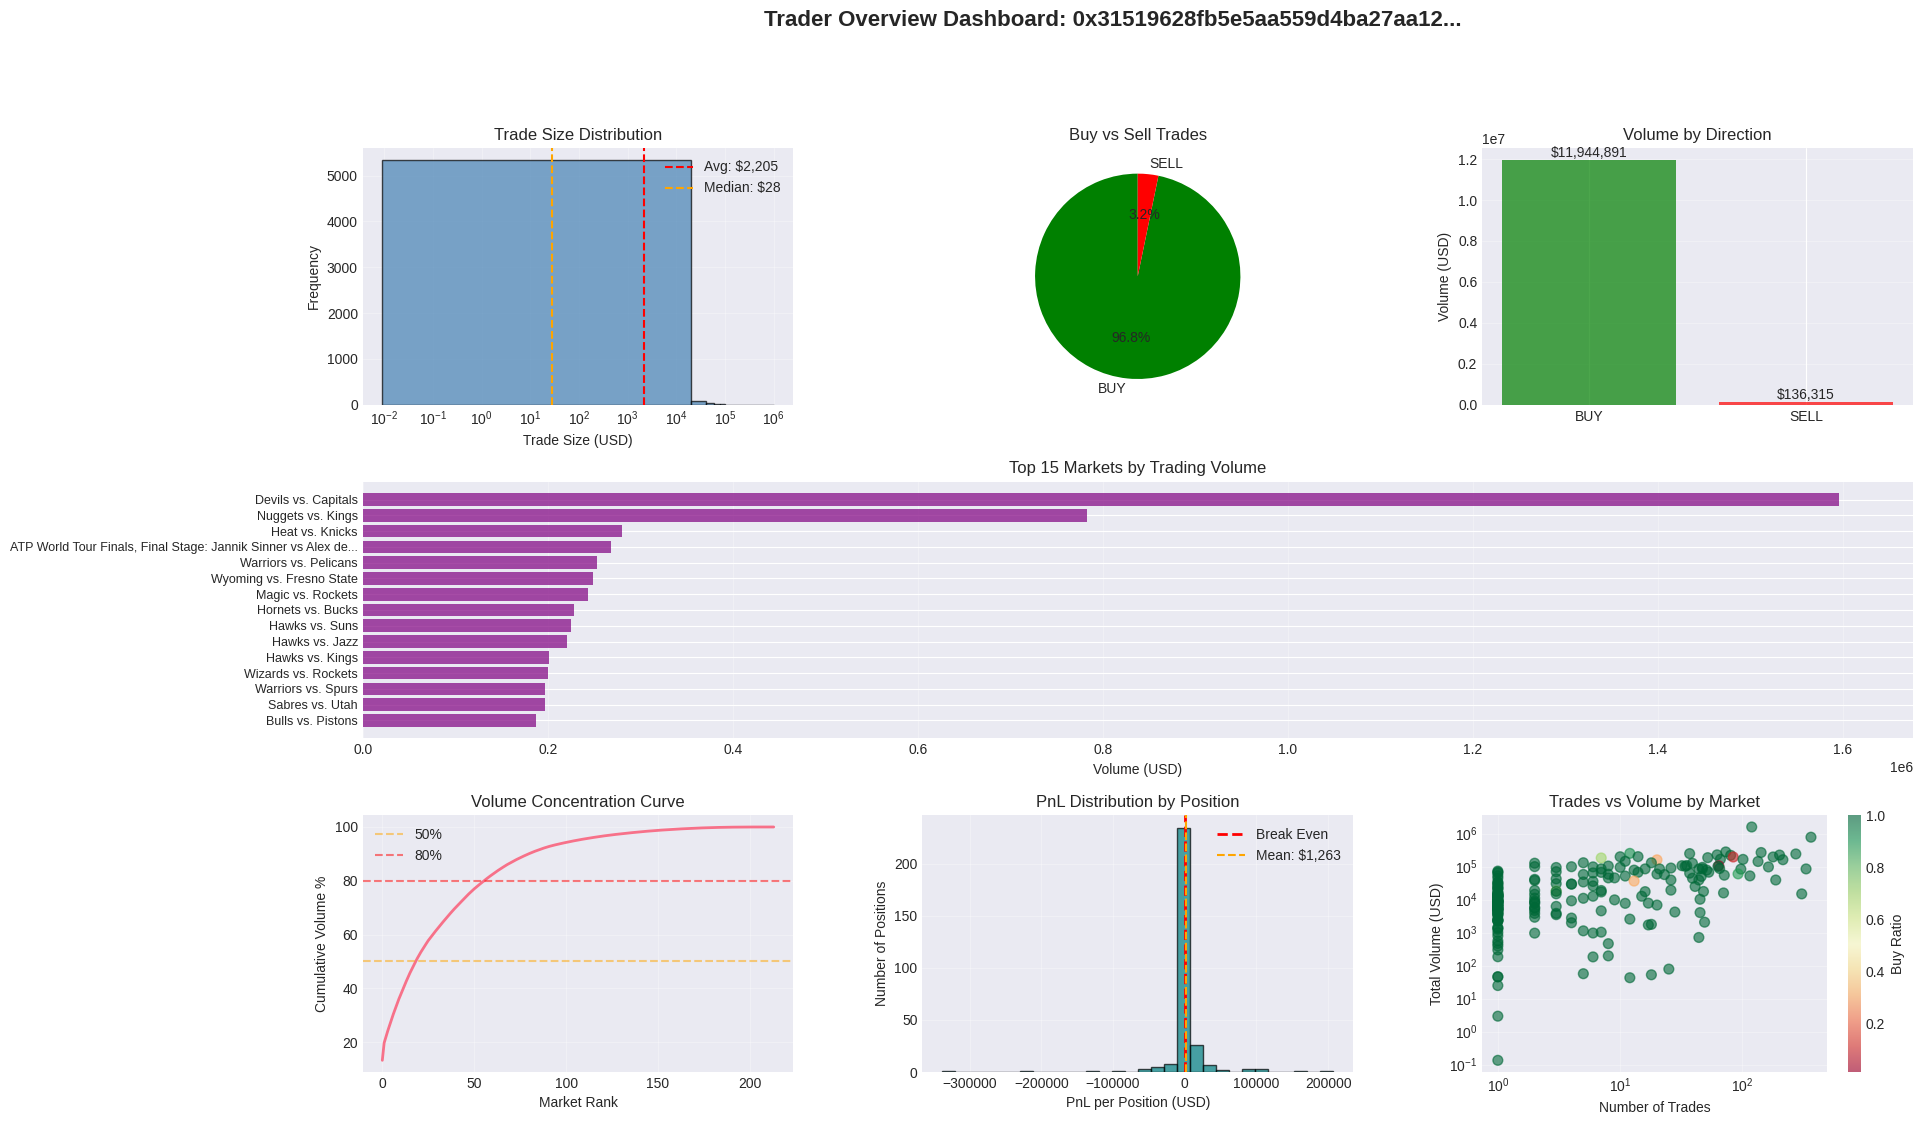

In [31]:
trader_trades_pd = trader_trades.to_pandas()
trader_markets_pd = trader_markets_full.to_pandas()
pnl_pd = pnl_with_markets.to_pandas()

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Trade Size Distribution
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(trader_trades_pd['usd_amount'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(stats['avg_trade_size'], color='red', linestyle='--', label=f"Avg: ${stats['avg_trade_size']:,.0f}")
ax1.axvline(stats['median_trade_size'], color='orange', linestyle='--', label=f"Median: ${stats['median_trade_size']:,.0f}")
ax1.set_xlabel('Trade Size (USD)')
ax1.set_ylabel('Frequency')
ax1.set_title('Trade Size Distribution')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Buy vs Sell
ax2 = fig.add_subplot(gs[0, 1])
directions = ['BUY', 'SELL']
counts = [stats['buy_trades'], stats['sell_trades']]
colors = ['green', 'red']
ax2.pie(counts, labels=directions, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Buy vs Sell Trades')

# 3. Volume by Direction
ax3 = fig.add_subplot(gs[0, 2])
volumes = [stats['buy_volume'], stats['sell_volume']]
ax3.bar(directions, volumes, color=colors, alpha=0.7)
ax3.set_ylabel('Volume (USD)')
ax3.set_title('Volume by Direction')
ax3.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(volumes):
    ax3.text(i, v, f'${v:,.0f}', ha='center', va='bottom')

# 4. Top 15 Markets by Volume
ax4 = fig.add_subplot(gs[1, :])
top_15 = trader_markets_pd.head(15)
y_pos = np.arange(len(top_15))
ax4.barh(y_pos, top_15['total_volume'], color='purple', alpha=0.7)
ax4.set_yticks(y_pos)
ax4.set_yticklabels([q[:60] + '...' if len(q) > 60 else q for q in top_15['question']], fontsize=9)
ax4.set_xlabel('Volume (USD)')
ax4.set_title('Top 15 Markets by Trading Volume')
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3, axis='x')

# 5. Market Concentration
ax5 = fig.add_subplot(gs[2, 0])
cumsum = trader_markets_pd['total_volume'].cumsum() / trader_markets_pd['total_volume'].sum() * 100
ax5.plot(range(len(cumsum)), cumsum, linewidth=2)
ax5.axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='50%')
ax5.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='80%')
ax5.set_xlabel('Market Rank')
ax5.set_ylabel('Cumulative Volume %')
ax5.set_title('Volume Concentration Curve')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. PnL Distribution
ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(pnl_pd['total_pnl'], bins=30, color='teal', edgecolor='black', alpha=0.7)
ax6.axvline(0, color='red', linestyle='--', linewidth=2, label='Break Even')
ax6.axvline(pnl_pd['total_pnl'].mean(), color='orange', linestyle='--', label=f"Mean: ${pnl_pd['total_pnl'].mean():,.0f}")
ax6.set_xlabel('PnL per Position (USD)')
ax6.set_ylabel('Number of Positions')
ax6.set_title('PnL Distribution by Position')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Trades per Market
ax7 = fig.add_subplot(gs[2, 2])
ax7.scatter(trader_markets_pd['num_trades'], trader_markets_pd['total_volume'], 
            c=trader_markets_pd['buy_ratio'], s=50, alpha=0.6, cmap='RdYlGn')
ax7.set_xlabel('Number of Trades')
ax7.set_ylabel('Total Volume (USD)')
ax7.set_title('Trades vs Volume by Market')
ax7.set_xscale('log')
ax7.set_yscale('log')
cbar = plt.colorbar(ax7.collections[0], ax=ax7)
cbar.set_label('Buy Ratio')
ax7.grid(True, alpha=0.3)

plt.suptitle(f'Trader Overview Dashboard: {TRADER_ADDRESS[:30]}...', fontsize=16, fontweight='bold', y=0.995)
plt.show()

## 7. Time-Based Behavior Analysis

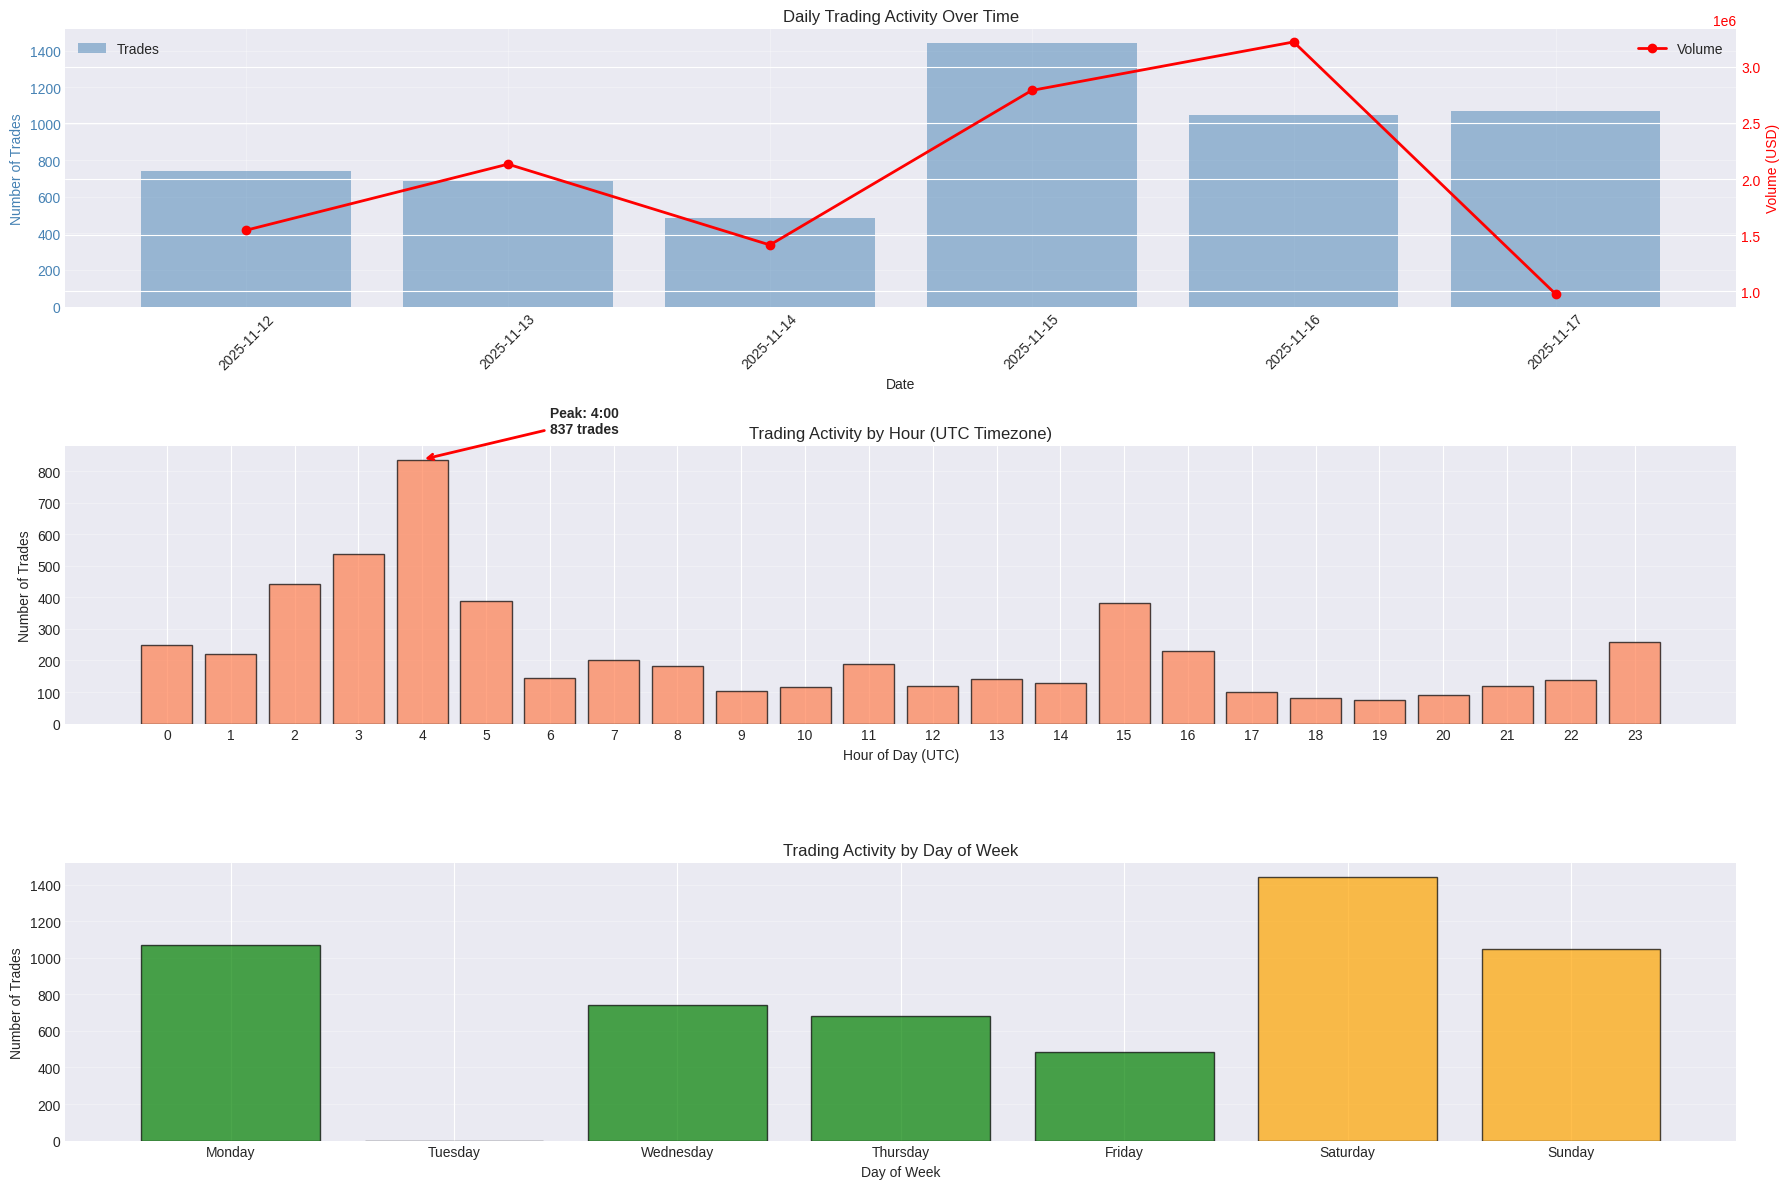


⏰ Time Pattern Insights:
Most active hour: 4:00 UTC (837 trades)
Most active day: Saturday (1444 trades)
Average trades per day: 913.0
Most active single day: 2025-11-15 00:00:00 (1444 trades)


In [32]:
# Add time features
trader_trades_time = trader_trades.with_columns([
    pl.col('timestamp').dt.date().alias('date'),
    pl.col('timestamp').dt.hour().alias('hour'),
    (pl.col('timestamp').dt.weekday() - 1).alias('weekday'),  # Convert 1-7 to 0-6
    pl.col('timestamp').dt.month().alias('month'),
])

# Daily activity
daily = (
    trader_trades_time
    .group_by('date')
    .agg(
        pl.len().alias('trades'),
        pl.col('usd_amount').sum().alias('volume'),
        pl.col('market_id').n_unique().alias('markets'),
    )
    .sort('date')
).to_pandas()

# Hourly pattern
hourly = (
    trader_trades_time
    .group_by('hour')
    .agg(
        pl.len().alias('trades'),
        pl.col('usd_amount').sum().alias('volume'),
    )
    .sort('hour')
).to_pandas()

# Weekday pattern
weekday = (
    trader_trades_time
    .group_by('weekday')
    .agg(
        pl.len().alias('trades'),
        pl.col('usd_amount').sum().alias('volume'),
    )
    .sort('weekday')
).to_pandas()

fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# 1. Daily Trading Activity
ax1 = axes[0]
ax1_twin = ax1.twinx()
ax1.bar(daily['date'], daily['trades'], alpha=0.5, color='steelblue', label='Trades')
ax1_twin.plot(daily['date'], daily['volume'], color='red', linewidth=2, marker='o', label='Volume')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Trades', color='steelblue')
ax1_twin.set_ylabel('Volume (USD)', color='red')
ax1.set_title('Daily Trading Activity Over Time')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Hourly Pattern
ax2 = axes[1]
ax2.bar(hourly['hour'], hourly['trades'], color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Hour of Day (UTC)')
ax2.set_ylabel('Number of Trades')
ax2.set_title('Trading Activity by Hour (UTC Timezone)')
ax2.set_xticks(range(24))
ax2.grid(True, alpha=0.3, axis='y')

# Add peak hours annotation
if len(hourly) > 0:
    peak_hour = hourly.loc[hourly['trades'].idxmax()]
    ax2.annotate(f'Peak: {int(peak_hour["hour"])}:00\n{int(peak_hour["trades"])} trades',
                 xy=(peak_hour['hour'], peak_hour['trades']),
                 xytext=(peak_hour['hour']+2, peak_hour['trades']*1.1),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2),
                 fontsize=10, fontweight='bold')

# 3. Weekday Pattern
ax3 = axes[2]
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors_weekday = ['green' if i < 5 else 'orange' for i in range(7)]  # Weekdays green, weekends orange

# Ensure all weekdays present (fill missing with 0)
all_weekdays = pd.DataFrame({'weekday': range(7)})
weekday_full = all_weekdays.merge(weekday, on='weekday', how='left').fillna(0)

ax3.bar(weekday_full['weekday'], weekday_full['trades'], 
        color=[colors_weekday[int(i)] for i in weekday_full['weekday']], 
        alpha=0.7, edgecolor='black')
ax3.set_xlabel('Day of Week')
ax3.set_ylabel('Number of Trades')
ax3.set_title('Trading Activity by Day of Week')
ax3.set_xticks(range(7))
ax3.set_xticklabels(weekday_names)
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n⏰ Time Pattern Insights:")
if len(hourly) > 0:
    print(f"Most active hour: {int(hourly.loc[hourly['trades'].idxmax(), 'hour'])}:00 UTC ({int(hourly['trades'].max())} trades)")
if len(weekday_full) > 0 and weekday_full['trades'].sum() > 0:
    most_active_idx = weekday_full['trades'].idxmax()
    most_active_day = int(weekday_full.loc[most_active_idx, 'weekday'])
    print(f"Most active day: {weekday_names[most_active_day]} ({int(weekday_full['trades'].max())} trades)")
if len(daily) > 0:
    print(f"Average trades per day: {daily['trades'].mean():.1f}")
    print(f"Most active single day: {daily.loc[daily['trades'].idxmax(), 'date']} ({int(daily['trades'].max())} trades)")

## 8. Trade Behavior Patterns

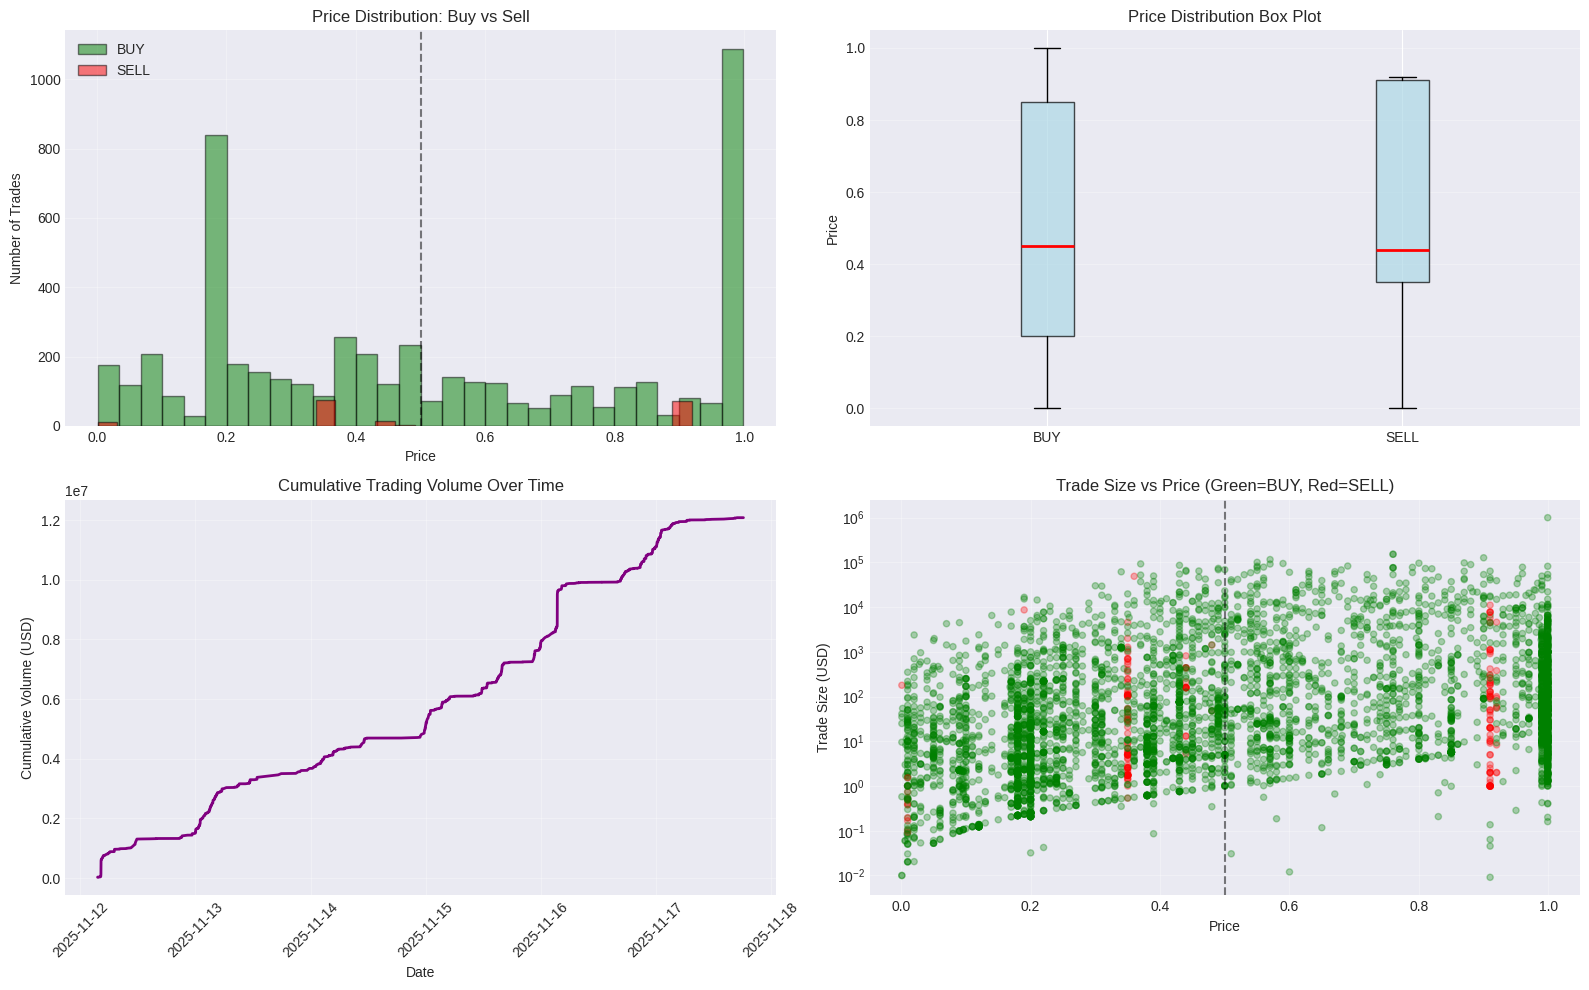


📊 Trading Behavior Insights:
Average BUY price: 0.514
Average SELL price: 0.568

Price preference:
  → Tends to BUY favorites (price > 0.5)
  → Tends to SELL favorites (price > 0.5)


In [33]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Price Distribution of Trades
ax1 = axes[0, 0]
buy_prices = trader_trades_pd[trader_trades_pd['maker_direction'] == 'BUY']['price']
sell_prices = trader_trades_pd[trader_trades_pd['maker_direction'] == 'SELL']['price']
ax1.hist(buy_prices, bins=30, alpha=0.5, color='green', label='BUY', edgecolor='black')
ax1.hist(sell_prices, bins=30, alpha=0.5, color='red', label='SELL', edgecolor='black')
ax1.set_xlabel('Price')
ax1.set_ylabel('Number of Trades')
ax1.set_title('Price Distribution: Buy vs Sell')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axvline(0.5, color='black', linestyle='--', alpha=0.5, label='50%')

# 2. Trade Size by Direction
ax2 = axes[0, 1]
ax2.boxplot([buy_prices, sell_prices], labels=['BUY', 'SELL'], 
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_ylabel('Price')
ax2.set_title('Price Distribution Box Plot')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Volume over Time (cumulative)
ax3 = axes[1, 0]
trader_trades_sorted = trader_trades_pd.sort_values('timestamp')
cumulative_volume = trader_trades_sorted['usd_amount'].cumsum()
ax3.plot(trader_trades_sorted['timestamp'], cumulative_volume, linewidth=2, color='purple')
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Volume (USD)')
ax3.set_title('Cumulative Trading Volume Over Time')
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# 4. Trade Size vs Price (colored by direction)
ax4 = axes[1, 1]
colors_scatter = ['green' if d == 'BUY' else 'red' for d in trader_trades_pd['maker_direction']]
ax4.scatter(trader_trades_pd['price'], trader_trades_pd['usd_amount'], 
           c=colors_scatter, alpha=0.3, s=20)
ax4.set_xlabel('Price')
ax4.set_ylabel('Trade Size (USD)')
ax4.set_title('Trade Size vs Price (Green=BUY, Red=SELL)')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)
ax4.axvline(0.5, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print insights
print("\n📊 Trading Behavior Insights:")
print(f"Average BUY price: {buy_prices.mean():.3f}")
print(f"Average SELL price: {sell_prices.mean():.3f}")
print(f"\nPrice preference:")
if buy_prices.mean() < 0.5:
    print("  → Tends to BUY underdogs (price < 0.5)")
else:
    print("  → Tends to BUY favorites (price > 0.5)")
    
if sell_prices.mean() < 0.5:
    print("  → Tends to SELL underdogs (price < 0.5)")
else:
    print("  → Tends to SELL favorites (price > 0.5)")

## 9. Trading Style Classification

🎭 TRADER PROFILE CLASSIFICATION
  🐋 WHALE
  📈 BUYER (Bullish)
  🌐 HIGHLY DIVERSIFIED
  🤖 HIGH FREQUENCY
  💵 MEDIUM POSITIONS
  🟢 WELL DISTRIBUTED


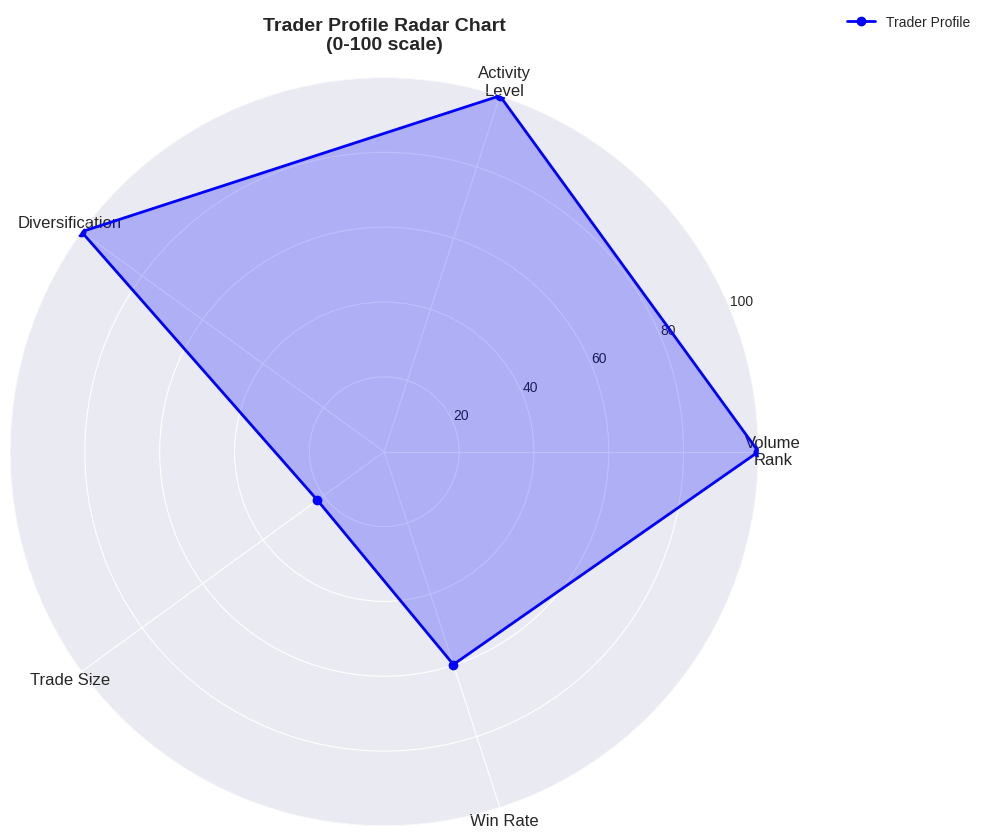

In [34]:
# Classify trader based on behavior
def classify_trader(stats_dict, markets_count):
    """
    Classify trader into categories based on behavior.
    """
    classifications = []
    
    # Volume-based
    if stats_dict['total_volume'] > 5_000_000:
        classifications.append('🐋 WHALE')
    elif stats_dict['total_volume'] > 1_000_000:
        classifications.append('🦈 SHARK')
    elif stats_dict['total_volume'] > 100_000:
        classifications.append('🐟 ACTIVE TRADER')
    else:
        classifications.append('🦐 SMALL TRADER')
    
    # Directional bias
    if stats_dict['buy_ratio'] > 0.7:
        classifications.append('📈 BUYER (Bullish)')
    elif stats_dict['buy_ratio'] < 0.3:
        classifications.append('📉 SELLER (Bearish/LP)')
    else:
        classifications.append('⚖️ BALANCED TRADER')
    
    # Market diversity
    if stats_dict['unique_markets'] > 100:
        classifications.append('🌐 HIGHLY DIVERSIFIED')
    elif stats_dict['unique_markets'] > 20:
        classifications.append('📊 DIVERSIFIED')
    else:
        classifications.append('🎯 FOCUSED/SPECIALIST')
    
    # Trade frequency
    if stats_dict['trades_per_day'] > 100:
        classifications.append('🤖 HIGH FREQUENCY')
    elif stats_dict['trades_per_day'] > 10:
        classifications.append('⚡ ACTIVE')
    else:
        classifications.append('🐌 CASUAL')
    
    # Trade size
    if stats_dict['avg_trade_size'] > 10_000:
        classifications.append('💰 LARGE POSITIONS')
    elif stats_dict['avg_trade_size'] > 1_000:
        classifications.append('💵 MEDIUM POSITIONS')
    else:
        classifications.append('🪙 SMALL POSITIONS')
    
    # Concentration
    top_1_pct = trader_markets['total_volume'][0] / trader_markets['total_volume'].sum() * 100
    if top_1_pct > 50:
        classifications.append('🔴 HIGHLY CONCENTRATED')
    elif top_1_pct > 25:
        classifications.append('🟡 MODERATELY CONCENTRATED')
    else:
        classifications.append('🟢 WELL DISTRIBUTED')
    
    return classifications

trader_profile = classify_trader(stats, len(trader_markets))

print("="*80)
print("🎭 TRADER PROFILE CLASSIFICATION")
print("="*80)
for classification in trader_profile:
    print(f"  {classification}")
print("="*80)

# Create a radar chart for key metrics
categories = ['Volume\nRank', 'Activity\nLevel', 'Diversification', 'Trade Size', 'Win Rate']

# Normalize metrics to 0-100 scale
volume_score = min((stats['total_volume'] / 10_000_000) * 100, 100)
activity_score = min((stats['trades_per_day'] / 100) * 100, 100)
diversity_score = min((stats['unique_markets'] / 200) * 100, 100)
size_score = min((stats['avg_trade_size'] / 10_000) * 100, 100)
win_rate_score = (len(winning) / (len(winning) + len(losing))) * 100 if (len(winning) + len(losing)) > 0 else 50

values = [volume_score, activity_score, diversity_score, size_score, win_rate_score]

# Number of variables
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
values += values[:1]  # Complete the circle
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
ax.plot(angles, values, 'o-', linewidth=2, color='blue', label='Trader Profile')
ax.fill(angles, values, alpha=0.25, color='blue')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'])
ax.grid(True)
ax.set_title('Trader Profile Radar Chart\n(0-100 scale)', size=14, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

## 10. Summary Report

In [35]:
print("="*80)
print("📋 COMPREHENSIVE TRADER ANALYSIS SUMMARY")
print("="*80)
print(f"\nTrader Address: {TRADER_ADDRESS}")
print(f"Analysis Period: {stats['first_trade']} to {stats['last_trade']}")
print(f"\n{'='*80}")
print("PROFILE CLASSIFICATION")
print(f"{'='*80}")
for classification in trader_profile:
    print(f"  {classification}")

print(f"\n{'='*80}")
print("KEY STATISTICS")
print(f"{'='*80}")
print(f"Total Volume:           ${stats['total_volume']:,.2f}")
print(f"Total Trades:           {stats['total_trades']:,}")
print(f"Unique Markets:         {stats['unique_markets']:,}")
print(f"Average Trade Size:     ${stats['avg_trade_size']:,.2f}")
print(f"Buy Ratio:              {stats['buy_ratio']:.1%}")
print(f"Trades per Day:         {stats['trades_per_day']:.1f}")

print(f"\n{'='*80}")
print("PERFORMANCE")
print(f"{'='*80}")
print(f"Total PnL:              ${total_pnl:,.2f}")
print(f"  Realized:             ${total_realized:,.2f}")
print(f"  Unrealized:           ${total_unrealized:,.2f}")
print(f"PnL %:                  {(total_pnl / stats['total_volume'] * 100):.2f}%")
print(f"Win Rate:               {len(winning)/(len(winning)+len(losing))*100:.1f}%")
print(f"Winning Positions:      {len(winning)}")
print(f"Losing Positions:       {len(losing)}")

print(f"\n{'='*80}")
print("MARKET CONCENTRATION")
print(f"{'='*80}")
print(f"Top 1 Market:           {top_1_pct:.1f}% of volume")
print(f"Top 5 Markets:          {top_5_pct:.1f}% of volume")
print(f"Top 10 Markets:         {top_10_pct:.1f}% of volume")

print(f"\n{'='*80}")
print("BEHAVIORAL INSIGHTS")
print(f"{'='*80}")
print(f"Most Active Hour:       {int(hourly.loc[hourly['trades'].idxmax(), 'hour'])}:00 UTC")
print(f"Most Active Day:        {weekday_names[int(weekday.loc[weekday['trades'].idxmax(), 'weekday'])]}")
print(f"Average BUY Price:      {buy_prices.mean():.3f}")
print(f"Average SELL Price:     {sell_prices.mean():.3f}")

# Top market
top_market = trader_markets_full.row(0, named=True)
print(f"\n{'='*80}")
print("TOP MARKET")
print(f"{'='*80}")
print(f"Question:               {top_market['question']}")
print(f"Volume:                 ${top_market['total_volume']:,.2f}")
print(f"Trades:                 {top_market['num_trades']:,}")
print(f"Buy Ratio:              {top_market['buy_ratio']:.1%}")
print(f"Ticker:                 {top_market['ticker']}")
print(f"\n{'='*80}")
print("Analysis Complete ✓")
print(f"{'='*80}")

📋 COMPREHENSIVE TRADER ANALYSIS SUMMARY

Trader Address: 0x31519628fb5e5aa559d4ba27aa1248810b9f0977
Analysis Period: 2025-11-12 03:35:15 to 2025-11-17 18:16:27

PROFILE CLASSIFICATION
  🐋 WHALE
  📈 BUYER (Bullish)
  🌐 HIGHLY DIVERSIFIED
  🤖 HIGH FREQUENCY
  💵 MEDIUM POSITIONS
  🟢 WELL DISTRIBUTED

KEY STATISTICS
Total Volume:           $12,081,205.77
Total Trades:           5,478
Unique Markets:         214
Average Trade Size:     $2,205.40
Buy Ratio:              96.8%
Trades per Day:         976.1

PERFORMANCE
Total PnL:              $376,284.33
  Realized:             $-11,808,575.50
  Unrealized:           $12,184,859.83
PnL %:                  3.11%
Win Rate:               59.8%
Winning Positions:      116
Losing Positions:       78

MARKET CONCENTRATION
Top 1 Market:           13.2% of volume
Top 5 Markets:          26.3% of volume
Top 10 Markets:         36.0% of volume

BEHAVIORAL INSIGHTS
Most Active Hour:       4:00 UTC
Most Active Day:        Saturday
Average BUY Price:     

## 11. Export Trader Report

In [36]:
def export_trader_report(trader_addr: str, output_dir: str = 'trader_reports'):
    """
    Export comprehensive trader analysis to CSV files.
    """
    from pathlib import Path
    export_path = Path(output_dir)
    export_path.mkdir(exist_ok=True)
    
    # Create subfolder for this trader
    trader_folder = export_path / trader_addr[:10]
    trader_folder.mkdir(exist_ok=True)
    
    # 1. All trades
    trader_trades.write_csv(trader_folder / 'all_trades.csv')
    
    # 2. Markets with full metadata
    trader_markets_full.write_csv(trader_folder / 'markets_traded.csv')
    
    # 3. PnL by position
    pnl_with_markets.write_csv(trader_folder / 'pnl_by_position.csv')
    
    # 4. Summary stats
    summary_df = pd.DataFrame([{
        'trader_address': trader_addr,
        'total_volume': stats['total_volume'],
        'total_trades': stats['total_trades'],
        'unique_markets': stats['unique_markets'],
        'buy_ratio': stats['buy_ratio'],
        'total_pnl': total_pnl,
        'realized_pnl': total_realized,
        'unrealized_pnl': total_unrealized,
        'win_rate': len(winning)/(len(winning)+len(losing)) if (len(winning)+len(losing)) > 0 else 0,
        'first_trade': stats['first_trade'],
        'last_trade': stats['last_trade'],
    }])
    summary_df.to_csv(trader_folder / 'summary.csv', index=False)
    
    print(f"✓ Exported trader report to {trader_folder}/")
    print(f"  - all_trades.csv")
    print(f"  - markets_traded.csv")
    print(f"  - pnl_by_position.csv")
    print(f"  - summary.csv")

# Uncomment to export
# export_trader_report(TRADER_ADDRESS)
print("\n✓ Export function ready. Uncomment the line above to run.")


✓ Export function ready. Uncomment the line above to run.
